# Optimization

In this notebook we will cover the how to optimize and fit parameter values to data using the `abm` package.

# Example Model

For this notebook we will use the same model and nominal parameter set as for the Simulations Notebook. You may use either the model file you created, or the "answers" model file (`../Model_Files/ModelFile_answers.model`) and the provided parameter table (`../Tables/ParameterTable.csv`)

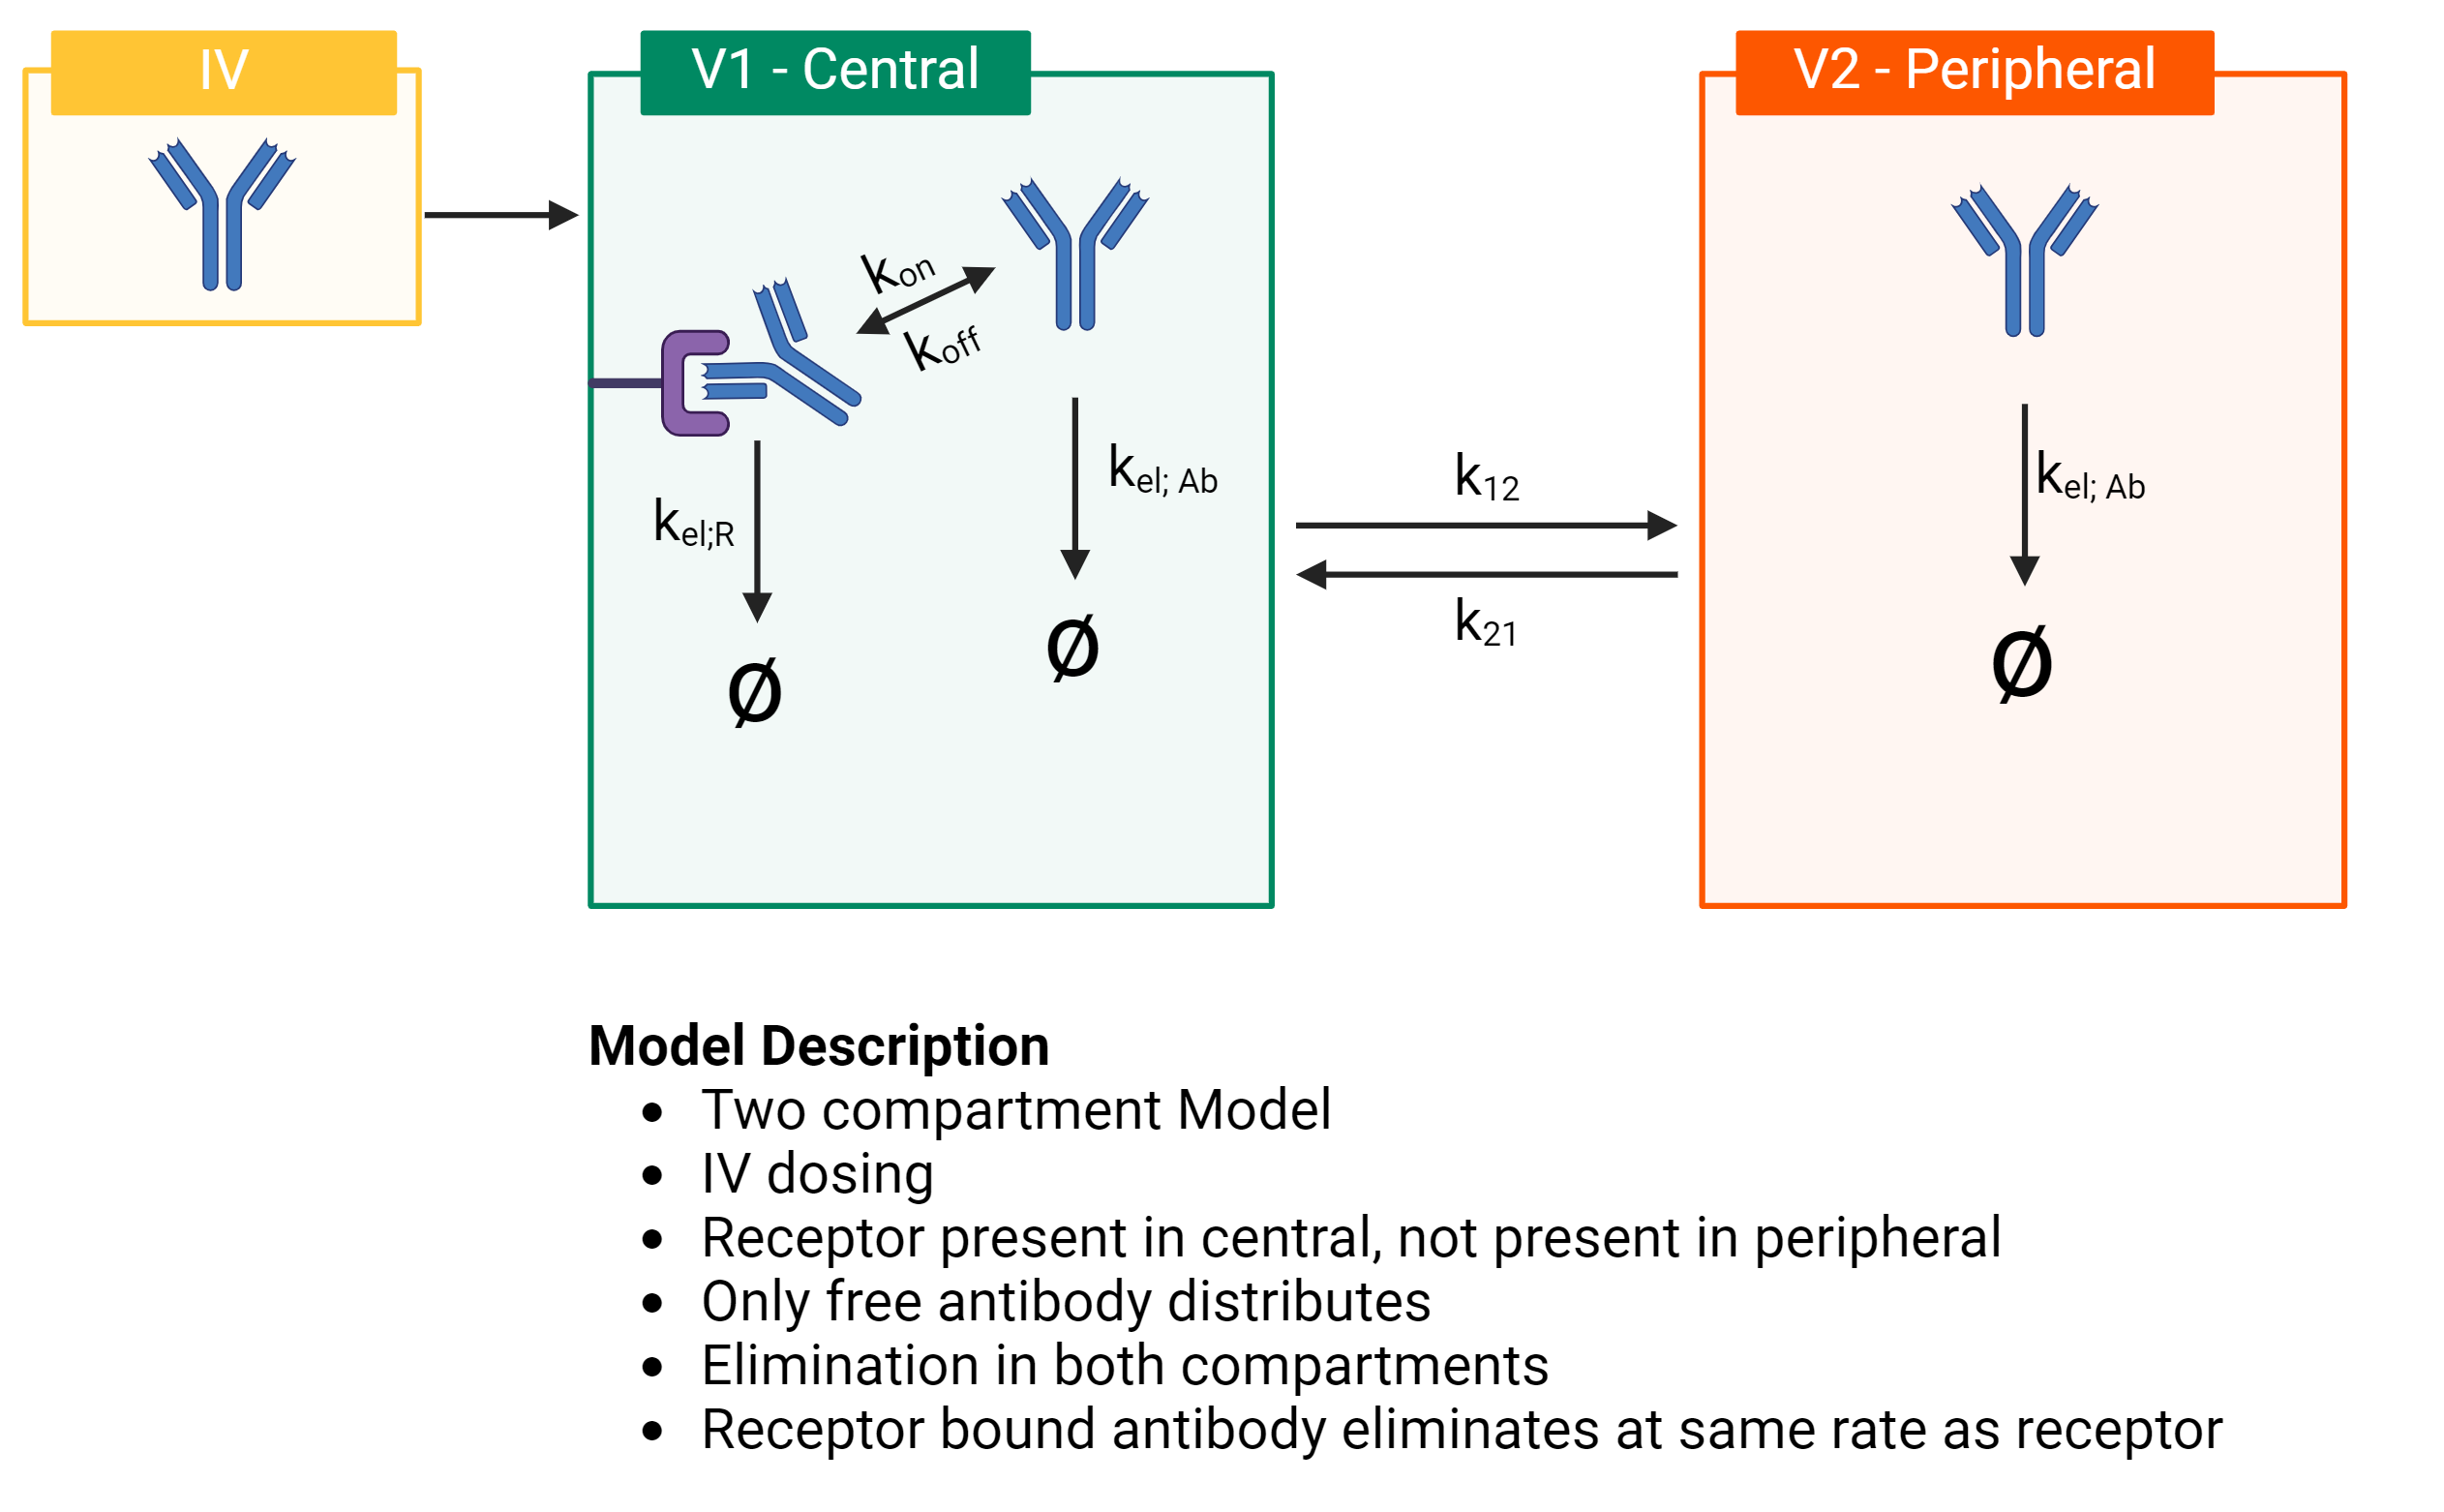

# Set up
Before beginning any modeling, we must load the necessary packages. It is also usually a good idea to load and view your nominal parameter tables and your data tables

## Set up task
 - Load `numpy` and `pandas` using a "short" name
 - Load `plotnine` and `abm` with whichever method you prefer
 - Load and display the nominal parameter table (`../Tables/ParameterTable.csv`)

In [1]:
import numpy as np
import pandas as pd
from plotnine import *
from abm import *

In [2]:
Tpar = pd.read_csv('../Tables/ParameterTable.csv')
display(Tpar)

,parameter,unit,value
0,volume_central,L,5.000
1,volume_peripheral,L,13.000
2,R_per_cell,1,10000.000
3,cell_per_mL,1/mL,1000000.000
4,kon,1/nM/s,0.001
5,kd_mab,nM,0.100
6,el_half,d,28.000
7,R_half,min,60.000
8,Pdist,1,0.120
9,Tdist_hr,hr,12.000


# Data Table
To be able to use the optimization tool in the `abm` package, your data needs to be formatted in a very specific way. Often times client data is not formatted in a way that we can use directly and you will have to modify it either manually or programatically. Because code is more easy to QC than manual edits, it is recommended that you become comfortable enough with `pandas` or other data frame packages to do this work programmatically.

For this example, we have provided you with a table at `"../Tables/Data.csv"` in the correct format.

## Data Table Format

For optimization purposes a data table must be a "tall" table with 7-8 required columns. These are the following
- `"time"` - These are the times at which measurements are taken. These can be in any standard time units ("fs", "ps", "ns", "us", "ms", "s", "min", "hr", "d", "w"). Individual entries can not be mised units (ie, you can not input 1 d 3 hr - this must be converted to 27 hr or 1.125 d)
- `"time_unit"` - These are the units of the time value in the same row
- `"output"` - This is the name of the measured variable in each row. The name must match the model file state variable exactly.
- `"measurement"` - This is the measured value of the relevant state variable in each row
- `"measurement_unit"` - This is the units of the measurement. The units must be compatible with the units of the state variable in the model file.
- At least one of the following error options: `"constant_error"`, `"exponential_error"`, or `"proportional_error"` which define the error for each data point.
    - A single row may have both `"constant_error"` and `"proportional_error"`, but if `"exponential_error"` is used then all other errors must be set to zero for that row. If you have a `"constant_error"` column, you must also include a `"constant_error_unit"` column as well. In this example we will use `"proportional_error"` for the PK measurement and set this equal to 0.1 and `"constant_Error"` for the RO and set it equal to 5%.
    - For more detailed information about the cost function used for each error type and how to choose these errors, see the optimization tutorial in the `"09_complete_workflows"` directory.
- A label column - This column matches the label column that you will use in your dose table to identify the simulation. Typically we use the dose for this purpose.

## Data Table Task
- Load the data Table located at `"../Tables/Data.csv"`
- display the first five rows of this data table to familiarize yourself with the format
- Plot the RO and PK data in two separate plots
    - RO should be with a linear y axis
    - PK should be with a log y axis

In [3]:
Tdat = pd.read_csv('../Tables/Data.csv')
display(Tdat.head())

,dose_mpk,output,time,time_unit,measurement,measurement_unit,proportional_error,constant_error,constant_error_unit
0,0.01,RO1,0.5,hr,48.703860,1,0.0,5,1
1,0.01,free_drug1_central,0.5,hr,4.555469,(nmol),0.1,0,nmol
2,0.01,RO1,1.0,hr,50.153978,1,0.0,5,1
3,0.01,free_drug1_central,1.0,hr,4.481521,(nmol),0.1,0,nmol
4,0.01,RO1,7.0,hr,45.762040,1,0.0,5,1


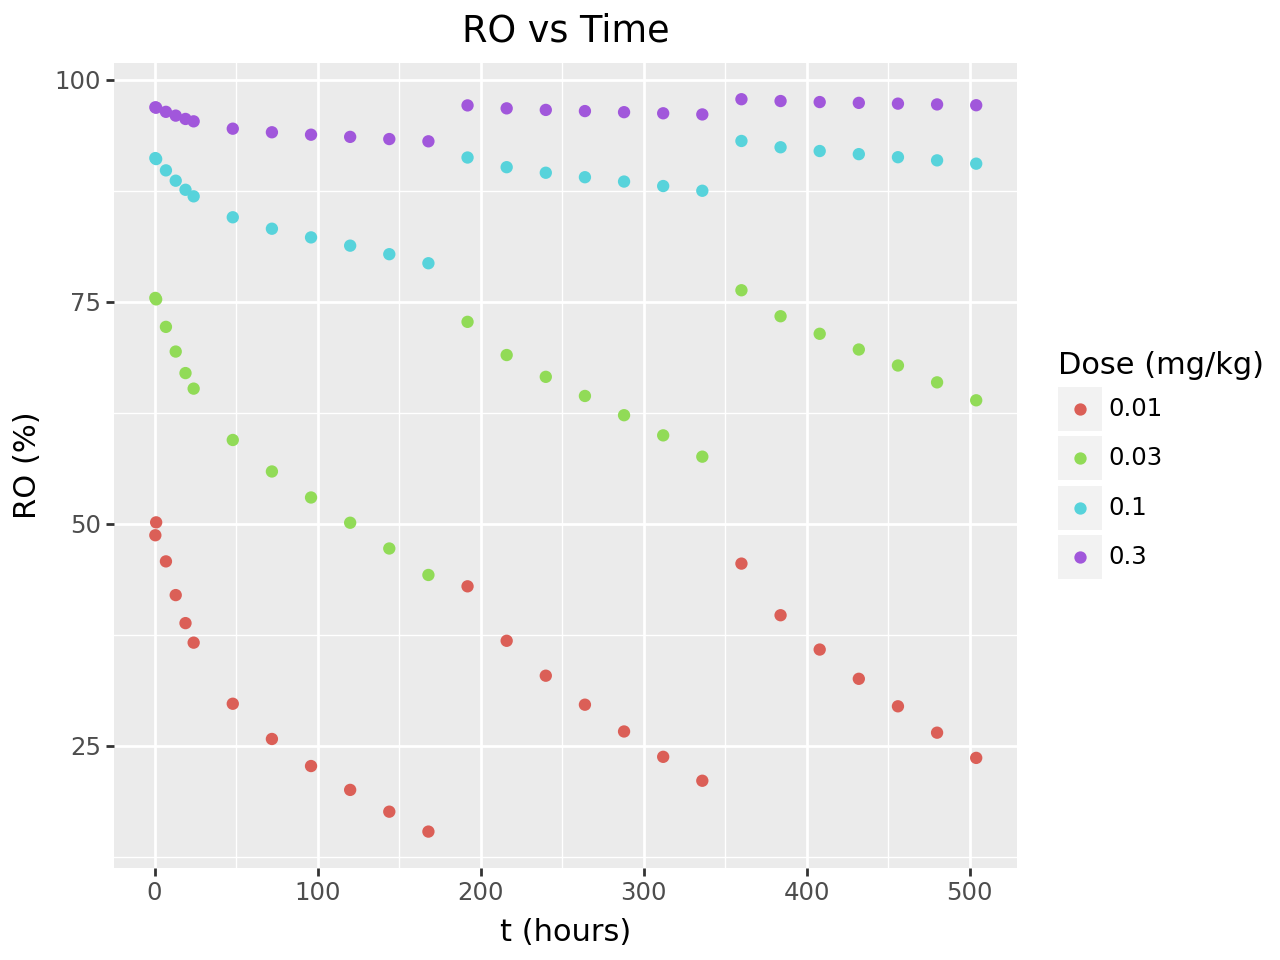

In [4]:
fig = (ggplot()
       + geom_point(data = Tdat.query('output == "RO1"'), mapping = aes(x = 'time', y = 'measurement', color = 'factor(dose_mpk)'))
       + labs(title = 'RO vs Time', x = 't (hours)', y = 'RO (%)', color = 'Dose (mg/kg)')
)

fig.show()

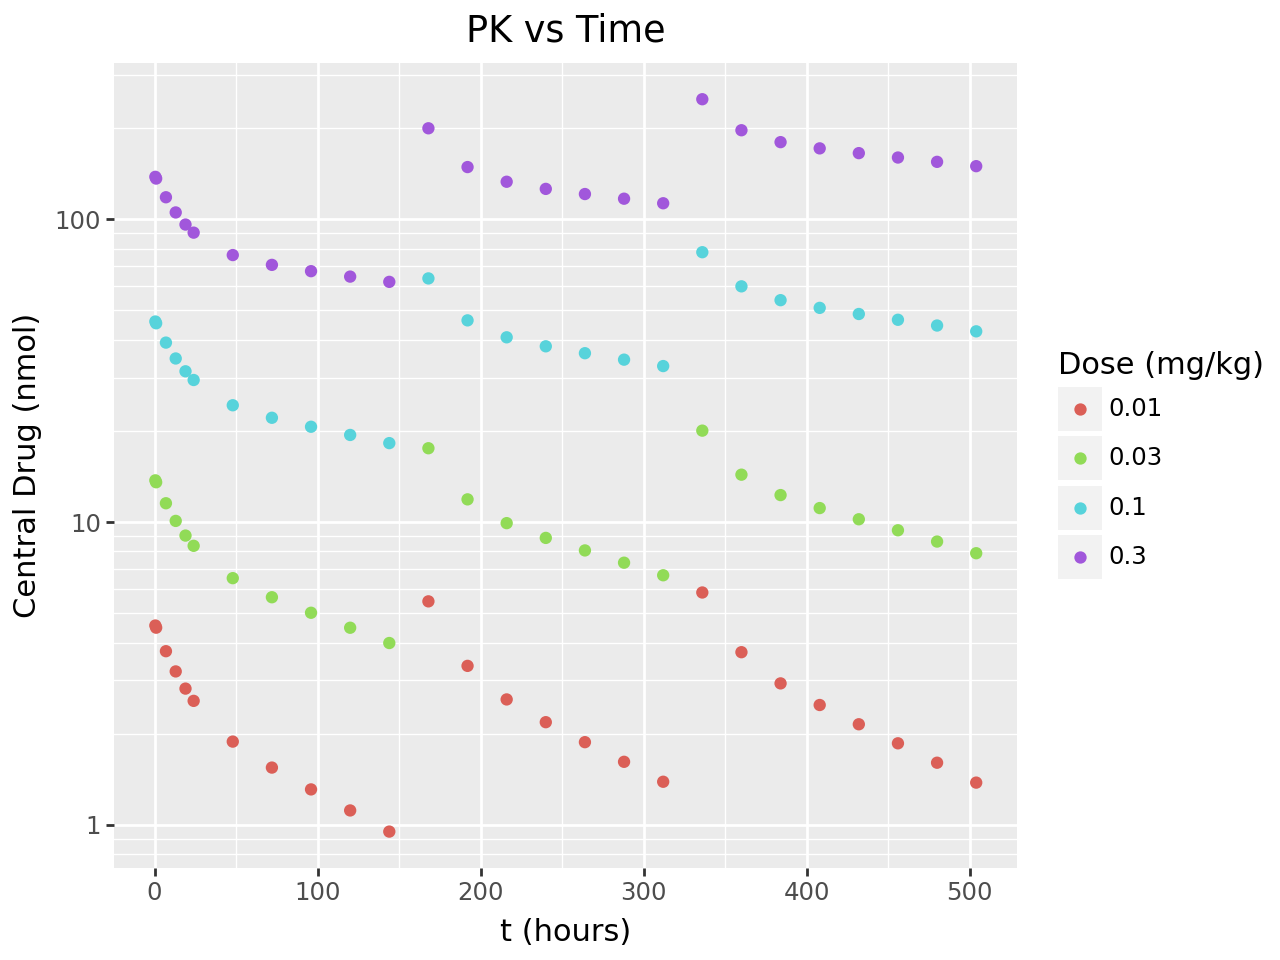

In [5]:
fig = (ggplot()
       + geom_point(data = Tdat.query('output == "free_drug1_central"'),
                    mapping = aes(x = 'time', y = 'measurement', color = 'factor(dose_mpk)'))
       + labs(title = 'PK vs Time', x = 't (hours)', y = 'Central Drug (nmol)', color = 'Dose (mg/kg)')
       + scale_y_log10()
)

fig.show()

# Dose Table
The dose table works the same way for optimization as it does for simulation. In the case of optimization, it is often a good idea to use the label columns from the data table to generate your dose table. That ensures that you have all of the correct doses in your dose table.

Recall that a dose table must contain

1. at least one label column (this must match the label column in the data table - `"dose_mpk"` in our example)
2. an `"amounts"` column - this is the amount of drug administered
3. an `"amount_unit"` column - this is the units of the drug administered
4. a `"times"` column - this is the times at which the drug is administered
6. a `"time_unit"` column - this is the unit of time at which the drug is administered
7. a `"route"` column - this is the route in the model file through which the drug is administered

## Dose Table Task
- Load the dose table from `"../Tables/DoseTable_filled.csv"` - we will use this to check our work
- Create a new dose table based on the data table and the required columns
    - *Note:* The `"times"` and `"time_unit"` columns in the data table correspond to when the measurement is collected, **not** when the dose is delivered
    - For this example, the doses are delivered at 0 days, 7 days, and 14 days
- Compare the two dose tables.
    - *Note:* In our example, the dose table used in the simulations example could be used for this optimization. But it is often the case that there are more doses or conditions saved in the data table than is easy to manually transcribe. So it can be simpler to extract that information from the data table.

In [6]:
Tdos_file = pd.read_csv('../Tables/DoseTable_filled.csv')
Tdos = Tdat.copy()[['dose_mpk']].drop_duplicates()
Tdos = Tdos.assign(amounts = Tdos.dose_mpk, amount_unit = "mg/kg", times = [[0, 7, 14]]*len(Tdos.dose_mpk.unique()),
                    time_unit = 'd', route = 'IV_mpk')

display(Tdos_file)
display(Tdos)

,dose_mpk,route,amounts,amount_unit,times,time_unit
0,0.01,IV_mpk,0.01,mg/kg,"[0,7,14]",d
1,0.03,IV_mpk,0.03,mg/kg,"[0,7,14]",d
2,0.10,IV_mpk,0.10,mg/kg,"[0,7,14]",d
3,0.30,IV_mpk,0.30,mg/kg,"[0,7,14]",d


,dose_mpk,amounts,amount_unit,times,time_unit,route
0,0.01,0.01,mg/kg,"[0, 7, 14]",d,IV_mpk
52,0.03,0.03,mg/kg,"[0, 7, 14]",d,IV_mpk
104,0.10,0.10,mg/kg,"[0, 7, 14]",d,IV_mpk
156,0.30,0.30,mg/kg,"[0, 7, 14]",d,IV_mpk


# Optimization Parameter Table

The optimization parameter table is very similar in structure to the parameter table we have already used. To create an optimization table, you will add 3 columns to your parameter table.

- `"is_fit"` - The entries of this column are either `True` or `False` based on if you want to fit the parameter on the corresponding row
- `"lower_bound"` - This is the lower bound allowed for parameter estimation. This value is only read if the parameter on the same row has an `"is_fit"` entry of `True`
- `"upper_bound"` - This is the upper bound allowed for parameter estimation. This value is only read if the parameter on the same row has an `"is_fit"` entry of `True`
- an *optional* `"prior_distribution"` column to define the prior for each parameter. The options are `"uniform"`, `"loguniform"`, `"normal"`, `"lognormal"`, `"laplace"`, or `"loglaplace"`. If this column is ommited, the default is `"loguniform"`. For this example, we will not include this column.
    - For more information and an example using this column, see the optimization tutorial in the `"09_complete_workflows"` directory.

You can add these columns by modifying the csv file manually or by entering the new columns in programatically. It is often useful to do this manually, if only to have a interactive version of the file in a shared drive with the biologist and team lead. This allows discussion about reasonable parameters to fit and also what biologically reasonable search ranges are.

For this example, we will fit the `"el_half"`, `"Pdist"`, and `"kd_mab"`. We have included a snippet of code that will create a new parameter table with the appropriate additional columns

## Parameter Table Task
- Read and understand the code in the following snippet.
- How would you change the bounds? How would you add another parameter to optimize? How would you add the optional `"prior_distribution"` column?

In [7]:
Tpar_fit = Tpar.copy().assign(is_fit = False, lower_bound = Tpar.value, upper_bound = Tpar.value)

fit_dict = {'el_half': [7, 49],
            'Pdist': [0, 1],
            'kd_mab' : [0.01, 10]}

for par in fit_dict.keys():
    Tpar_fit.loc[Tpar_fit.parameter == par, 'lower_bound'] = fit_dict[par][0]
    Tpar_fit.loc[Tpar_fit.parameter == par, 'upper_bound'] = fit_dict[par][1]
    Tpar_fit.loc[Tpar_fit.parameter == par, 'is_fit'] = True

display(Tpar_fit)

,parameter,unit,value,is_fit,lower_bound,upper_bound
0,volume_central,L,5.000,False,5.000,5.000
1,volume_peripheral,L,13.000,False,13.000,13.000
2,R_per_cell,1,10000.000,False,10000.000,10000.000
3,cell_per_mL,1/mL,1000000.000,False,1000000.000,1000000.000
4,kon,1/nM/s,0.001,False,0.001,0.001
5,kd_mab,nM,0.100,True,0.010,10.000
6,el_half,d,28.000,True,7.000,49.000
7,R_half,min,60.000,False,60.000,60.000
8,Pdist,1,0.120,True,0.000,1.000
9,Tdist_hr,hr,12.000,False,12.000,12.000


# Running the Fit

We use a function called `optimize` in the `abm` package to optimize our parameter values to the data with the following syntax:

```
optimize(
    measurements = {data table or file path to data table},
    models = {path to model},
    parameters = {parameter table or file path to parameter table},
    doses = {dose table or file path to dose table},
    method="fides-BFGS",
    max_iterations=1000,
    min_objective=-np.inf,
    opttol=1e-8,
    gradient_method="forward",
    linear_solver="KLU",
    reltol=1e-6,
    abstol=1e-9,
    maxord=5,
    nonnegative=False
)
```

The `measurements`, `models`, `parameters`, and `doses` columns are required. All others are optional and relate to numerical optimization hyperparameters.

*Note:* If you imported the `abm` package using `import abm` or `import abm as abm`, then you would use `abm.optimize` for this function

## Fit output

When the optimization finishes running, the output is saved as an `OptimizationResult`. The information you are most interested in must be extracted from that result to be most useful to you. Some of the useful objects from a `OptimizationResult` are

- The fitted parameter table - this is an attribute
- The best fit simulation - this is a method
- The residuals - this is a method
- Confidence intervals - this is a method
- Profile Likelihood - this is a method

In this workshop we'll discuss the first two items of the list. For the others, see further documentation in the examples folder, check the V2 documentation, or reach out on the slack channel.

### Fitted parameter table

To read the parameter table, you need to extract the information from the `OptimizationResult`. This is done by calling the `.fit_parameter_table` attribute on the result of the optimize function. This parameter table is the same as the input parameter table, but the fitted values have been replaced by their optimized values. The attribute itself can be returned in several different formats (different types of tables). There is more information in the `"09_complete_workflows/psf_optimizations.ipynb"` notebook. For the purposes of this training, we will use a `pandas` data frame.

To output a `pandas` dataframe, attache `.to_pandas()` to your parameter output using this syntax `Tpar_result = optimization.fit_parameter_table.to_pandas()` where `optimization` is the output of the `optimize()` function above.

### Simulate Fitted parameters

To run a simulation with the new fitted parameters and compare it to the data, you have two options:

1. use the `simulate` function from the `abm` package as you did in the Simulations Notebook. This is the syntax

```
simulate(models = {Model File},
        parameters = {Parameter Table},
        doses = {Dose Table},
        simulations = {Simulation Table},
        outputs = {Output List},
        times = {Times List or Table}).to_pandas(tall_outputs = True)
```


2. use the `simulate` method attached to the `OptimizationResult` object. This is the syntax

``` optimization.simulate(
        times = {Times List or Table},
        outputs = {Ouptut List}).to_pandas(tall_outputs = True)
```

The first method is slightly more cumbersome, as you must include all the information you had used in the optimization as well as include a simulation table. The second method is streamlined and the `times` and `outputs` arguments are optional (if they are not included, then the output times and output states of the simulation will match the measurements in the data).

The main reason you might use the first option is if you want to simulate doses or conditions that are not present in the data. This is often very useful when validating or predicting.

## Optimization Tasks

- Fit the parameters to your data.
    - Define the output of the fit as `optimization`
-  Extract the fitted parameter table
    -  Name this parameter table `Tpar_results`
    -  Display the full parameter table
    -  Display just the fitted values
-  Simulate the fitted parameters using either method
    -  Output times should range from 0-21 days with sufficiently small step size that the curves look smooth
    -  Plot these results along with the data
-  Simulate the nominal parameter set
    -  add this to the previous plot with dashed lines to compare to the fitted parameter set

In [8]:
#Fit Parameters

optimization = optimize(
    measurements = Tdat,
    models = '../Model_Files/ModelFile_answers.model',
    parameters = Tpar_fit,
    doses = Tdos,
)

Total: 2, Running: 0, Succeeded: 2, Failed: 0

iteration,objective,kd_mab_fit_5,el_half_fit_6,Pdist_fit_8
0,8432.764739,0.100000,28.000000,0.120000
1,733.258248,0.732329,31.655176,0.195461
2,733.258248,0.732329,31.655176,0.195461
3,507.133042,0.697700,26.544084,0.253493
4,507.133042,0.697700,26.544084,0.253493
5,458.914701,0.683596,24.672048,0.285951
6,458.914701,0.683596,24.672048,0.285951
7,454.823696,0.717967,23.743151,0.299064
8,454.823696,0.717967,23.743151,0.299064
9,454.052504,0.696057,23.762516,0.299709


In [9]:
#Display Parameters
Tpar_result = optimization.fit_parameter_table.to_pandas()
display(Tpar_result)

display(Tpar_result.query('is_fit == True'))

,parameter,unit,value,is_fit,lower_bound,upper_bound,global_parameter_name
0,volume_central,L,5.000000,False,5.000,5.000,volume_central_fit_0
1,volume_peripheral,L,13.000000,False,13.000,13.000,volume_peripheral_fit_1
2,R_per_cell,1,10000.000000,False,10000.000,10000.000,R_per_cell_fit_2
3,cell_per_mL,1/mL,1000000.000000,False,1000000.000,1000000.000,cell_per_mL_fit_3
4,kon,1/nM/s,0.001000,False,0.001,0.001,kon_fit_4
5,kd_mab,nM,0.692246,True,0.010,10.000,kd_mab_fit_5
6,el_half,d,25.191756,True,7.000,49.000,el_half_fit_6
7,R_half,min,60.000000,False,60.000,60.000,R_half_fit_7
8,Pdist,1,0.308327,True,0.000,1.000,Pdist_fit_8
9,Tdist_hr,hr,12.000000,False,12.000,12.000,Tdist_hr_fit_9


,parameter,unit,value,is_fit,lower_bound,upper_bound,global_parameter_name
5,kd_mab,nM,0.692246,True,0.01,10.0,kd_mab_fit_5
6,el_half,d,25.191756,True,7.00,49.0,el_half_fit_6
8,Pdist,1,0.308327,True,0.00,1.0,Pdist_fit_8


In [10]:
#Simulate Fitted Parameters
Tres_fit = optimization.simulate(times = linspace(0,21,211,'d')).to_pandas(tall_outputs = True)

Total: 5, Running: 0, Succeeded: 5, Failed: 0

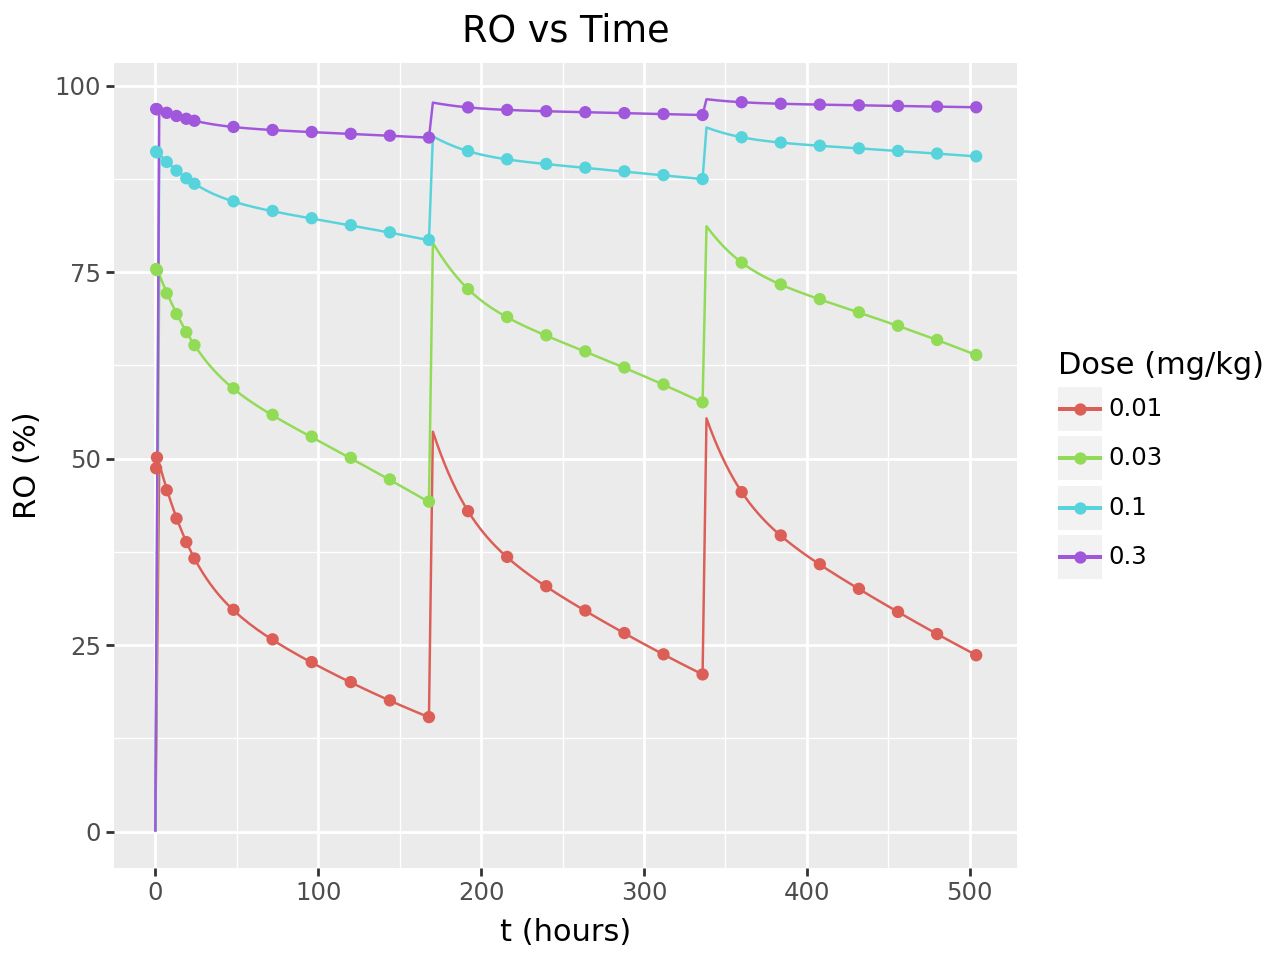

In [11]:
#Plot Simulations vs Data - RO
fig = (ggplot()
       + geom_line(data = Tres_fit.query('output == "RO1"'),
                   mapping = aes(x = 't/(3600)', y = 'value', color = 'factor(dose_mpk)'))
       + geom_point(data = Tdat.query('output == "RO1"'),
                    mapping = aes(x = 'time', y = 'measurement', color = 'factor(dose_mpk)'))
       + labs(title = 'RO vs Time', x = 't (hours)', y = 'RO (%)', color = 'Dose (mg/kg)')
)

fig.show()

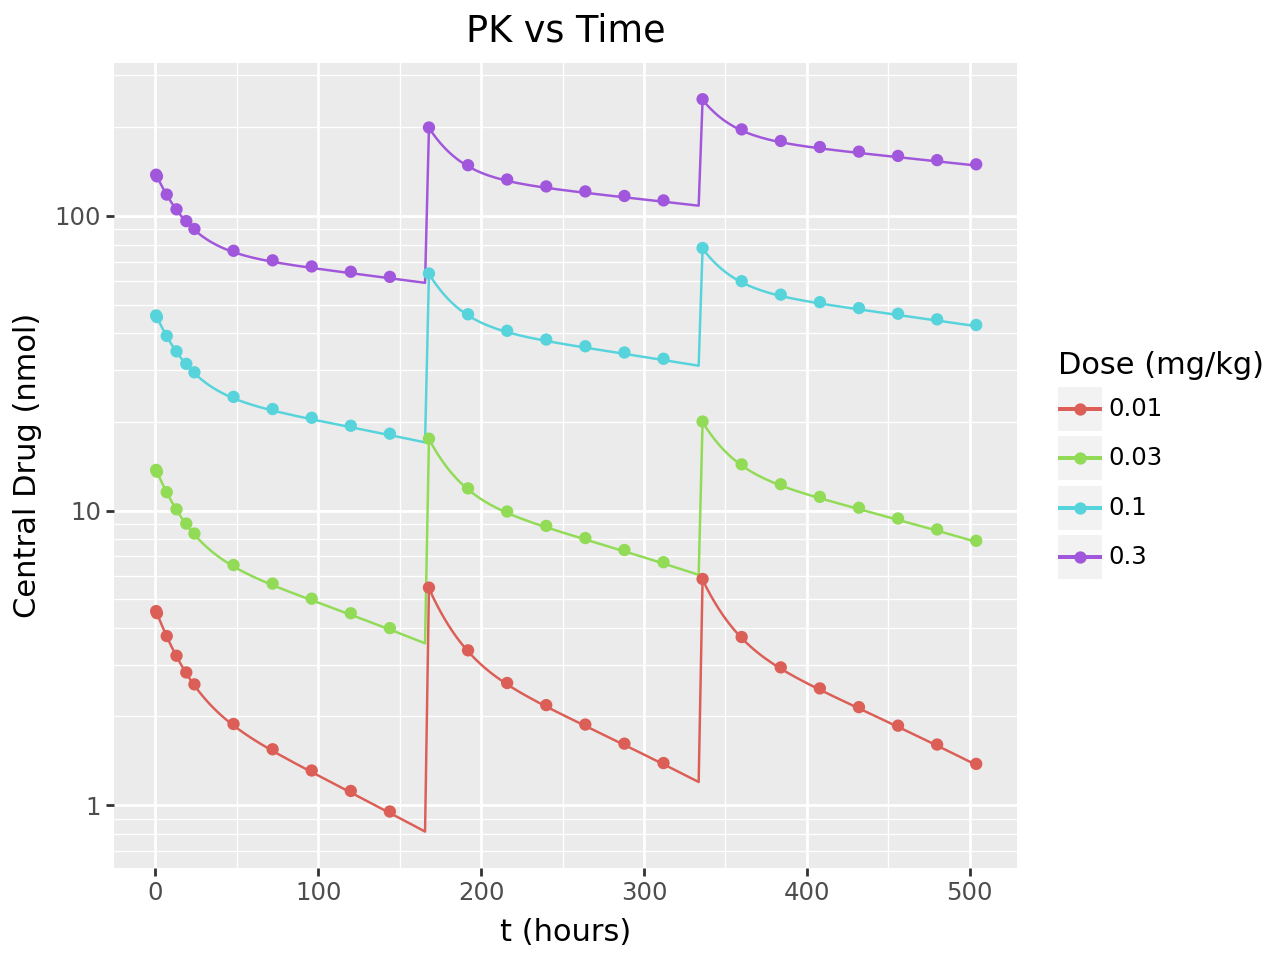

In [12]:
#Plot Simulations vs Data - PK
fig = (ggplot()
       + geom_line(data = Tres_fit.query('output == "free_drug1_central"'),
                   mapping = aes(x = 't/(3600)', y = 'value', color = 'factor(dose_mpk)'))
       + geom_point(data = Tdat.query('output == "free_drug1_central"'),
                    mapping = aes(x = 'time', y = 'measurement', color = 'factor(dose_mpk)'))
       + labs(title = 'PK vs Time', x = 't (hours)', y = 'Central Drug (nmol)', color = 'Dose (mg/kg)')
       + scale_y_log10()
)

fig.show()

In [13]:
# Simulate Nominal Parameters
Tnominal = simulate(models = '../Model_Files/ModelFile_answers.model',
                parameters = Tpar,
                doses = Tdos,
                simulations = Tdos[['dose_mpk']],
                outputs = ['RO1', 'free_drug1_central'],
                times = linspace(0,21,211,'d')).to_pandas(tall_outputs = True)

Total: 5, Running: 0, Succeeded: 5, Failed: 0

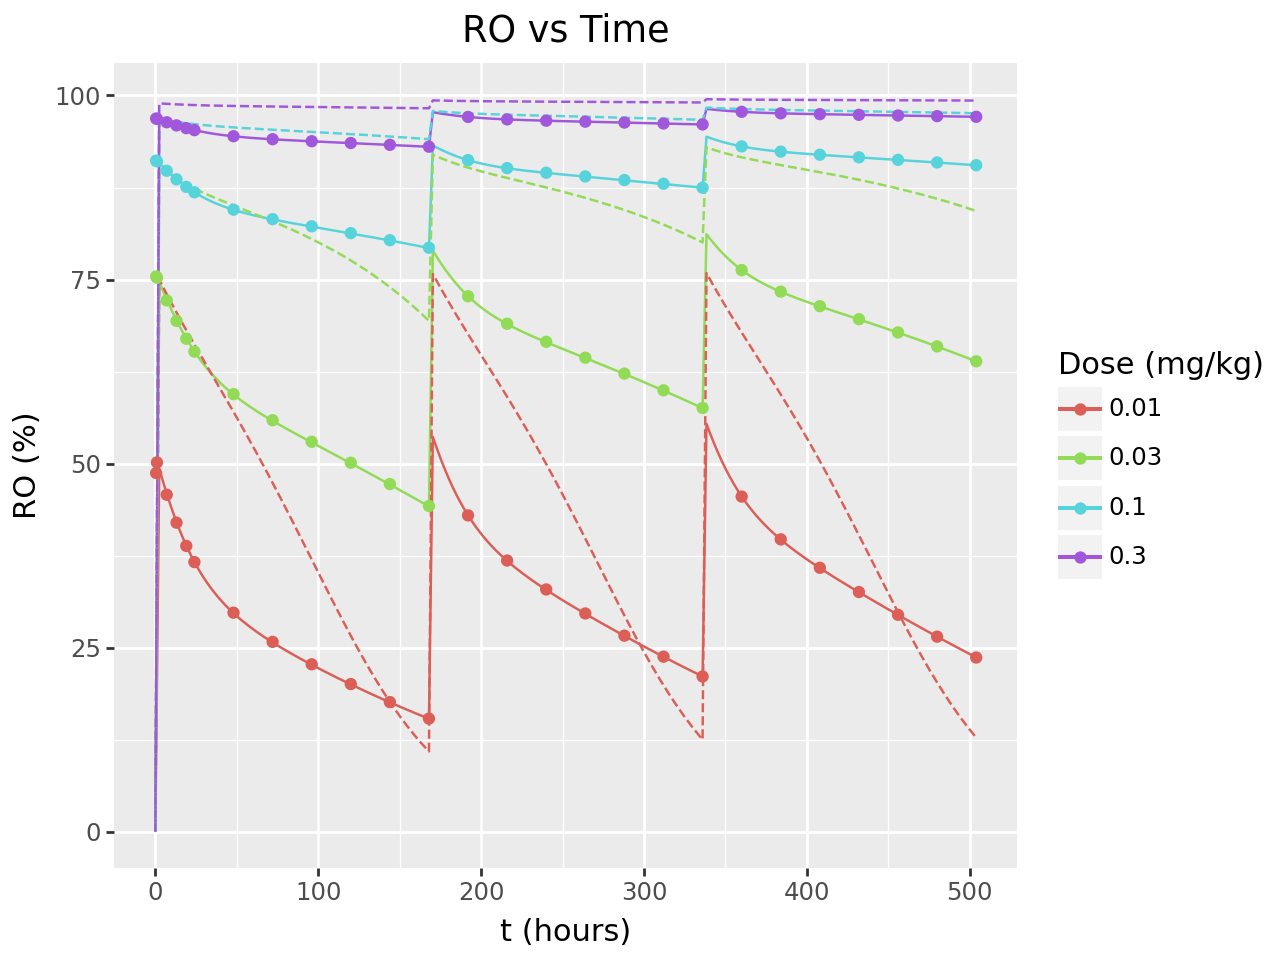

In [14]:
#Plot simulation vs data - RO
fig = (ggplot()
       + geom_line(data = Tres_fit.query('output == "RO1"'),
                   mapping = aes(x = 't/(3600)', y = 'value', color = 'factor(dose_mpk)'))
       + geom_line(data = Tnominal.query('output == "RO1"'),
                   mapping = aes(x = 't/(3600)', y = 'value', color = 'factor(dose_mpk)'), linetype = 'dashed')
       + geom_point(data = Tdat.query('output == "RO1"'),
                    mapping = aes(x = 'time', y = 'measurement', color = 'factor(dose_mpk)'))
       + labs(title = 'RO vs Time', x = 't (hours)', y = 'RO (%)', color = 'Dose (mg/kg)')
)

fig.show()

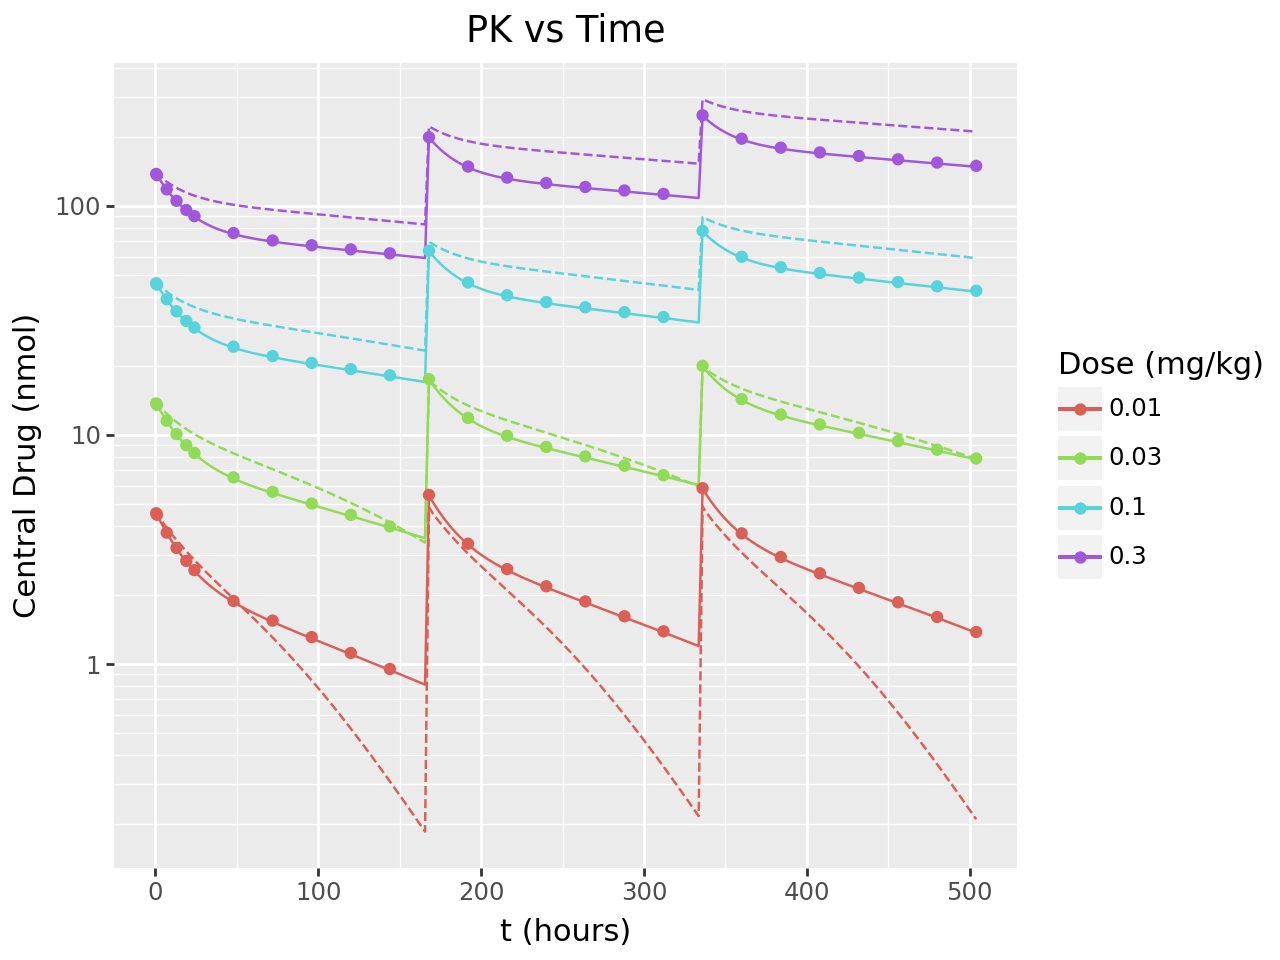

In [15]:
#Plot simulation vs data - PK

fig = (ggplot()
       + geom_line(data = Tres_fit.query('output == "free_drug1_central"'),
                   mapping = aes(x = 't/(3600)', y = 'value', color = 'factor(dose_mpk)'))
       + geom_line(data = Tnominal.query('output == "free_drug1_central"'),
                   mapping = aes(x = 't/(3600)', y = 'value', color = 'factor(dose_mpk)'), linetype = 'dashed')
       + geom_point(data = Tdat.query('output == "free_drug1_central"'),
                    mapping = aes(x = 'time', y = 'measurement', color = 'factor(dose_mpk)'))
       + labs(title = 'PK vs Time', x = 't (hours)', y = 'Central Drug (nmol)', color = 'Dose (mg/kg)')
       + scale_y_log10()
)

fig.show()